In [20]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
from astropy.table import QTable
%matplotlib notebook

import seaborn as sns
pal = sns.color_palette("colorblind")

import pickle

from pymccorrelation import pymccorrelation
import linmix

from scipy.stats import kendalltau
from seaborn.algorithms import bootstrap

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [21]:
#Load Data
summed_columns = QTable.read("Data/SUMMED_ION_COLUMNS.fits")




In [23]:
# summed_columns["SOURCE","RHO_LMC", "LOG_N_CIV","LOG_N_ERR_CIV","LOG_N_SiIV",
#                "LOG_N_ERR_SiIV", "LOG_N_OVI", "LOG_N_ERR_OVI"].write("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/Figure2_SourceData.csv")


In [22]:
summed_columns

SOURCE,RHO_LMC,MEAN_CIV_V,LOG_N_OVI,LOG_N_ERR_OVI,LOG_N_CIV,LOG_N_ERR_CIV,LOG_N_SiIV,LOG_N_ERR_SiIV,LOG_N_CII,LOG_N_ERR_CII,LOG_N_SiII,LOG_N_ERR_SiII,LOG_N_SiIII,LOG_N_ERR_SiIII,LOG_N_AlII,LOG_N_ERR_AlII,LOG_N_FeII,LOG_N_ERR_FeII,LOG_N_OI,LOG_N_ERR_OI,GAL_LON,GAL_LAT
,kpc,,,,,,,,,,,,,,,,,,,,deg,deg
bytes23,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
PKS0637-75,6.6777271801538625,315.21209141225086,--,--,13.847500042416913,0.21486380232322203,13.023835640364153,0.5834980364754688,14.592223957303432,0.20825515522942822,14.423482925766141,0.05965410886436371,13.943778188150093,0.11270708941170897,13.04697716400103,0.10184503532865698,14.34355276410756,0.09105571480132185,15.120269343978967,0.1621508215075317,286.3683639918138,-27.158416955795435
HE0246-4101,28.825902516579085,--,--,--,12.981771111610092,-1.0,12.90625051328287,0.09087708138797361,14.454491193099607,0.0314211379546636,13.985330626860792,0.030371764799867952,13.872228473994195,0.5783835389656298,12.697159077902358,0.12130725843288087,13.95290739153146,0.15751291176463264,13.264662529903703,-1.0,250.16044154586777,-62.40148587222074
RBS144,28.589275460501888,181.12309569155778,13.874134462156777,0.10900524502448398,13.111985886935148,0.13628899426228863,12.19051614380182,-1.0,13.867881652947965,0.03906319793496885,12.728003183988772,0.03615444078856229,12.862999592175289,0.04087709294311042,11.655409049885188,-1.0,13.097197668583595,-1.0,13.748984570547393,-1.0,299.48369588633375,-65.83616648873654
PKS0552-640,5.548363813437074,361.99659836006555,14.390315012963955,-1.0,13.874675995667005,0.1846756233686016,12.451331517447395,0.18747038876643973,14.856101080776329,0.13473122594024226,14.232661082789123,0.07775236711870939,13.99398163764152,0.1514998958590301,13.212104181402346,0.1003447437663694,14.038385439196457,0.2253596788523948,14.699398372260832,0.11851215583123938,273.4655755409904,-30.611442195488028
PKS0202-76,13.323103840073875,275.8650137714024,--,--,13.445831605889019,0.21566071528656142,12.818391107782787,0.22672379738340956,14.814676037521908,0.6817968089522809,14.598577647820482,0.05350045542988317,14.174878848266244,0.2341701268572903,13.331226184956481,0.1235015766150336,14.424421417080833,0.1984660328967396,15.240034082557358,0.13499753644187712,297.54865746073773,-40.04515968380045
HE0003-5023,32.46658316833735,--,--,--,12.538038259787562,-1.0,12.073105125154955,-1.0,12.672290827079202,-1.0,11.257679148935926,-1.0,11.60977936887398,-1.0,11.678059820471963,-1.0,12.947329831446304,-1.0,--,--,320.7097875454362,-65.40537537289745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HE2336-5540,30.93240492300965,--,14.118326289010186,-1.0,12.709070030741062,-1.0,12.372347443650337,-1.0,12.873767209646072,-1.0,11.807213639072447,-1.0,11.829676261715681,-1.0,11.989687930329888,-1.0,13.089416279625663,-1.0,13.272305593426536,-1.0,322.8252451074142,-58.85345393202218


# Statistical Tests

In [4]:
# SiIV

# Prepare Data for Stat Tests

XX = summed_columns["RHO_LMC"].value

YY = np.copy(summed_columns["LOG_N_SiIV"])
YY_err = np.copy(summed_columns["LOG_N_ERR_SiIV"])
has_UL = YY_err < 0



Ylim = np.zeros_like(XX, dtype = int)
Ylim[has_UL] = 1
Xlim = np.zeros_like(XX, dtype = int)

coeff = "kendallt"
Nboot = 10000

xS = XX
yS = YY
yS_err = YY_err
xlimS = Xlim
ylimS = Ylim

kwargs = {"return_dist":True}

# Correlation Test for Si
res = pymccorrelation(xS, yS, xlim = xlimS, ylim = ylimS, 
            coeff = coeff, Nboot = Nboot, **kwargs)


out = {}

out["coeff_percentiles"] = res[0]
out["p-value_percentiles"] = res[1]
out["coeff_dist"] = res[2]
out["p-value_dist"] = res[3]




YY = np.copy(summed_columns["LOG_N_CIV"])
YY_err = np.copy(summed_columns["LOG_N_ERR_CIV"])
has_UL = YY_err < 0

Ylim = np.zeros_like(XX, dtype = int)
Ylim[has_UL] = 1

Xlim = np.zeros_like(XX, dtype = int)

coeff = "kendallt"
Nboot = 10000

xC = XX
yC = YY
yC_err = YY_err
xlimC = Xlim
ylimC = Ylim

kwargs = {"return_dist":True}


# Correlation Test for C
res = pymccorrelation(xC, yC, xlim = xlimC, ylim = ylimC, 
            coeff = coeff, Nboot = Nboot, **kwargs)


outC = {}

outC["coeff_percentiles"] = res[0]
outC["p-value_percentiles"] = res[1]
outC["coeff_dist"] = res[2]
outC["p-value_dist"] = res[3]





mc_data = {
    "Ion":np.concatenate([["SiIV"]*len(out["coeff_dist"]),["CIV"]*len(outC["coeff_dist"])]),
    r"Kendall's $\tau$":np.concatenate([out["coeff_dist"], outC["coeff_dist"]]),
    r"$\log_{10}$(p-value)":np.log10(np.concatenate([out["p-value_dist"], outC["p-value_dist"]]))
}






In [5]:
#OVI
ovi_mask = ~np.isnan(summed_columns["LOG_N_OVI"]) & (summed_columns["LOG_N_ERR_OVI"] > 0)
OVI_KendallTau = kendalltau(XX[ovi_mask], summed_columns["LOG_N_OVI"][ovi_mask])
print(OVI_KendallTau)


def boot_OVI_tau(inds):
    x = XX[ovi_mask][inds]
    y = summed_columns["LOG_N_OVI"][ovi_mask] + np.random.randn(len(inds)) * summed_columns["LOG_N_ERR_OVI"][ovi_mask]
    return kendalltau(x, y)

boot_OVI_KendallTau = bootstrap(np.arange(ovi_mask.sum()), func = boot_OVI_tau, Nboot = 10000)

print(np.percentile(boot_OVI_KendallTau[:,1][~np.isnan(boot_OVI_KendallTau[:,1])], (16,50,84)))
print(np.percentile(boot_OVI_KendallTau[:,0][~np.isnan(boot_OVI_KendallTau[:,0])], (16,50,84)))

KendalltauResult(correlation=-0.7333333333333333, pvalue=0.05555555555555555)
[0.15017991 0.44421673 0.84549398]
[-0.38924947  0.          0.38924947]


In [6]:
# Correlation Test for points with rho>7 kpc for CIV and SiIV

gt7_maskC = xC>7
gt7_resC = pymccorrelation(xC[gt7_maskC], yC[gt7_maskC], 
                           xlim = xlimC[gt7_maskC], ylim = ylimC[gt7_maskC], 
            coeff = coeff, Nboot = Nboot, **kwargs)

gt7_maskS = xS>7
gt7_resS = pymccorrelation(xS[gt7_maskS], yS[gt7_maskS], 
                           xlim = xlimS[gt7_maskS], ylim = ylimS[gt7_maskS], 
            coeff = coeff, Nboot = Nboot, **kwargs)

In [7]:
gt7_outC = {}

gt7_outC["coeff_percentiles"] = gt7_resC[0]
gt7_outC["p-value_percentiles"] = gt7_resC[1]
gt7_outC["coeff_dist"] = gt7_resC[2]
gt7_outC["p-value_dist"] = gt7_resC[3]

gt7_out = {}

gt7_out["coeff_percentiles"] = gt7_resS[0]
gt7_out["p-value_percentiles"] = gt7_resS[1]
gt7_out["coeff_dist"] = gt7_resS[2]
gt7_out["p-value_dist"] = gt7_resS[3]



gt7_mc_data = {
    "Ion":np.concatenate([["SiIV"]*len(gt7_out["coeff_dist"]),["CIV"]*len(gt7_outC["coeff_dist"])]),
    r"Kendall's $\tau$":np.concatenate([gt7_out["coeff_dist"], gt7_outC["coeff_dist"]]),
    r"$\log_{10}$(p-value)":np.log10(np.concatenate([gt7_out["p-value_dist"], gt7_outC["p-value_dist"]]))
}

In [8]:
# Linear Regression
## All Data

upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC, yC, xsig_C, ysig_C, delta=delta_C, K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

xx = np.linspace(0,37,1000)
all_lines_C = np.array([m*xx + b for (m,b) in zip(slopes_C, yints_C)])

lo_line_C, med_line_C, hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
mean_line_C = mean_slope_C*xx + mean_yint_C


delta_S = np.invert(upper_lim_S)
xsig_S = np.zeros_like(xS)
ysig_S = yS_err[:]
lmcens_S = linmix.LinMix(xS, yS, xsig_S, ysig_S, delta=delta_S, K=2)
lmcens_S.run_mcmc(silent=True)

yints_S = lmcens_S.chain['alpha']
slopes_S = lmcens_S.chain['beta']


mean_yint_S = yints_S.mean()
mean_slope_S = slopes_S.mean()

xx = np.linspace(0,37,1000)
all_lines_S = np.array([m*xx + b for (m,b) in zip(slopes_S, yints_S)])

lo_line_S, med_line_S, hi_line_S = np.percentile(all_lines_S, (16,50,84), axis = 0)
mean_line_S = mean_slope_S*xx + mean_yint_S






In [9]:
# Linear Regression
## rho > 7 kpc

upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0

delta_C = np.invert(upper_lim_C)
xsig_C = np.zeros_like(xC)
ysig_C = yC_err[:]
lmcens_C = linmix.LinMix(xC[xC>7], yC[xC>7], xsig_C[xC>7], ysig_C[xC>7], delta=delta_C[xC>7], K=2)
lmcens_C.run_mcmc(silent=True)

yints_C = lmcens_C.chain['alpha']
slopes_C = lmcens_C.chain['beta']


mean_yint_C = yints_C.mean()
mean_slope_C = slopes_C.mean()

gt7_xx = np.linspace(0,37,1000)
all_lines_C = np.array([m*gt7_xx + b for (m,b) in zip(slopes_C, yints_C)])

gt7_lo_line_C, gt7_med_line_C, gt7_hi_line_C = np.percentile(all_lines_C, (16,50,84), axis = 0)
gt7_mean_line_C = mean_slope_C*gt7_xx + mean_yint_C


delta_S = np.invert(upper_lim_S)
xsig_S = np.zeros_like(xS)
ysig_S = yS_err[:]
lmcens_S = linmix.LinMix(xS[xS>7], yS[xS>7], xsig_S[xS>7], ysig_S[xS>7], delta=delta_S[xS>7], K=2)
lmcens_S.run_mcmc(silent=True)

yints_S = lmcens_S.chain['alpha']
slopes_S = lmcens_S.chain['beta']


mean_yint_S = yints_S.mean()
mean_slope_S = slopes_S.mean()

gt7_xx = np.linspace(0,37,1000)
all_lines_S = np.array([m*gt7_xx + b for (m,b) in zip(slopes_S, yints_S)])

gt7_lo_line_S, gt7_med_line_S, gt7_hi_line_S = np.percentile(all_lines_S, (16,50,84), axis = 0)
gt7_mean_line_S = mean_slope_S*gt7_xx + mean_yint_S

In [10]:
# OVI
from scipy.stats import siegelslopes
from seaborn.algorithms import bootstrap


def slope_finder(inds, y = summed_columns["LOG_N_OVI"][ovi_mask], 
                 x = summed_columns["RHO_LMC"][ovi_mask], 
                 y_err = summed_columns["LOG_N_ERR_OVI"][ovi_mask]):
    xx = x[inds]
    yy = y[inds] + y_err * np.random.randn(len(inds))
    return siegelslopes(yy, x = xx)

slope_O, intercept_O = bootstrap(np.arange(ovi_mask.sum()), func = slope_finder, n_boot = 10000).T
slope_O = slope_O[~np.isnan(slope_O)]
intercept_O = intercept_O[~np.isnan(intercept_O)]

mean_slope_O = slope_O.mean()
mean_yint_O = intercept_O.mean()
std_slope_O = slope_O.std()

# O_xx = np.linspace(0,50,1000)
O_xx = np.linspace(summed_columns["RHO_LMC"][ovi_mask].min().value,
                   summed_columns["RHO_LMC"][ovi_mask].max().value ,1000)


all_lines_O = np.array([m*O_xx + b for (m,b) in zip(slope_O, intercept_O)])


lo_line_O, med_line_O, hi_line_O = np.percentile(all_lines_O, (16,50,84), axis = 0)
mean_line_O = mean_slope_O*xx + mean_yint_O



# Figure 2

<IPython.core.display.Javascript object>


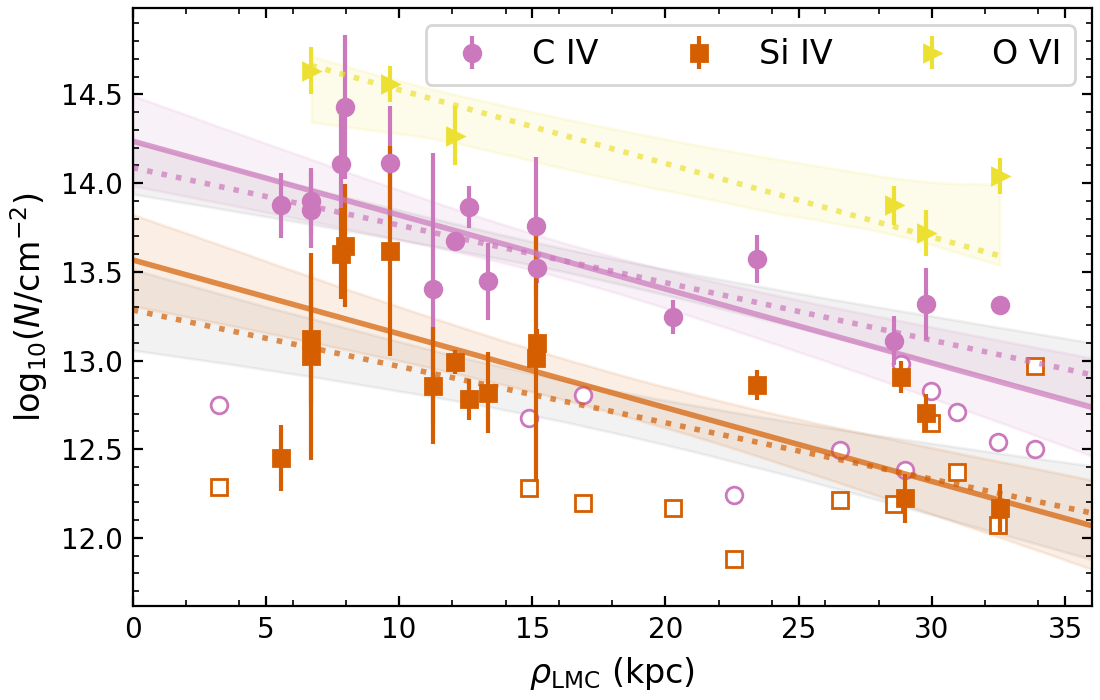

In [11]:
fig,ax = plt.subplots(constrained_layout = True, figsize = (5.5, 3.5))

axd = {"A":ax}


palette = [pal[3], pal[4]]


upper_lim_S = yS_err < 0
upper_lim_C = yC_err < 0



axd["A"].plot(xC[upper_lim_C], yC[upper_lim_C], "o",
                 markeredgecolor = palette[1], markerfacecolor = "w", markersize = 6)


axd["A"].plot(xS[upper_lim_S], yS[upper_lim_S], "s",
                 markeredgecolor = palette[0], markerfacecolor = "w", markersize = 6)




# #add arrows
# for x,y in zip(xC[upper_lim_C], yC[upper_lim_C]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[1], head_width = .5, head_length = .05)
    
# for x,y in zip(xS[upper_lim_S], yS[upper_lim_S]):
#     axd["A"].arrow(x,y,0,-0.25,color = palette[0], head_width = .5, head_length = .05)




axd["A"].errorbar(xC[~upper_lim_C], yC[~upper_lim_C], 
                  yC_err[~upper_lim_C], fmt = "o", 
                  color=palette[1], label = "C IV")
axd["A"].errorbar(xS[~upper_lim_S], yS[~upper_lim_S], 
                  yS_err[~upper_lim_S], fmt = "s",
                  color=palette[0], label = "Si IV")



axd["A"].errorbar(summed_columns["RHO_LMC"][ovi_mask], summed_columns["LOG_N_OVI"][ovi_mask], 
                  summed_columns["LOG_N_ERR_OVI"][ovi_mask], fmt = ">",
                  color=pal[8], label = "O VI")





xlim = axd["A"].get_xlim()

axd["A"].plot(xx, mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_C, hi_line_C, color = "k", alpha = 0.05)


axd["A"].plot(xx, mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(xx, lo_line_S, hi_line_S, color = "k", alpha = 0.05)



axd["A"].plot(xx, gt7_mean_line_C, color = palette[1], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_C, gt7_hi_line_C, color = palette[1], alpha = 0.1)


axd["A"].plot(xx, gt7_mean_line_S, color = palette[0], lw = 2, alpha = 0.7, ls = "-")
axd["A"].fill_between(gt7_xx, gt7_lo_line_S, gt7_hi_line_S, color = palette[0], alpha = 0.1)

axd["A"].plot(O_xx, mean_line_O, color = pal[8], lw = 2, alpha = 0.7, ls = ":")
axd["A"].fill_between(O_xx, lo_line_O, hi_line_O, color = pal[8], alpha = 0.1)




xlim = axd["A"].set_xlim(xlim)


lg = axd["A"].legend(fontsize = 12, ncol = 3)
for lh in lg.legendHandles: 
    lh.set_alpha(1)

axd["A"].set_xlabel(r"$\rho_\mathrm{LMC}$ (kpc)", fontsize = 12)
axd["A"].set_ylabel(r"$\log_{10}(N/\mathrm{cm}^{-2})$", fontsize = 12)

ax.xaxis.set_minor_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlim(0,36)

ax.tick_params(which = "both", direction = "in", top = True, right = True)



# Statistical Test Figure
## Extended Data Figure 6

<IPython.core.display.Javascript object>


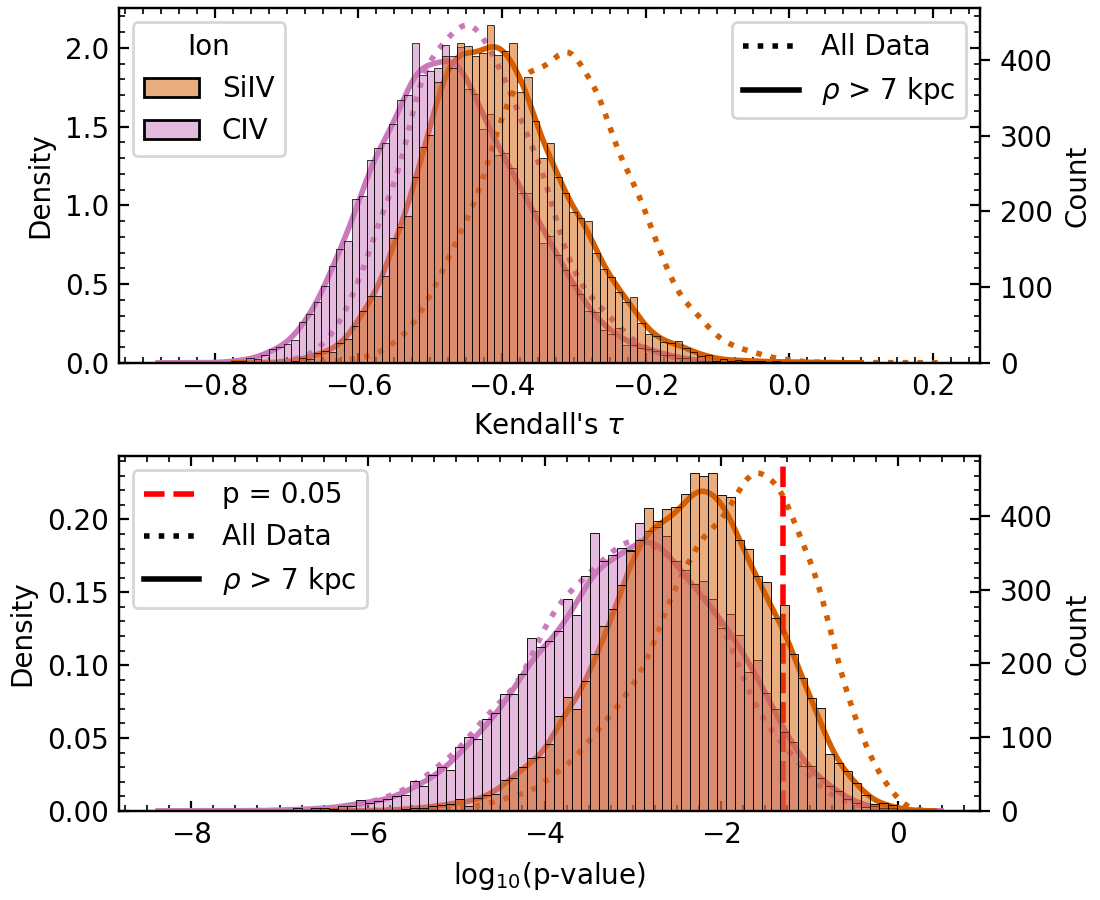

In [12]:
fig,axs = plt.subplots(2,1,constrained_layout = True, figsize = (5.5, 4.5))

axd = {"B":axs[0], "C":axs[1]}


palette = [pal[3], pal[4]]



sns.kdeplot(data = mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = ":", lw = 2)
sns.kdeplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
            ax = axd["B"], legend = False, ls = "-", lw = 2)

axt = axd["B"].twinx()
sns.histplot(data = gt7_mc_data, x = r"Kendall's $\tau$", hue = "Ion", palette = palette, 
             ax = axt, legend = True)

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)
    
move_legend(axt, "upper left")

axd["B"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["B"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["B"].legend(loc = 1)
for lh in lg.legendHandles: 
    lh.set_alpha(1)



sns.kdeplot(data = mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = ":")
sns.kdeplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
            ax = axd["C"], legend = False, lw = 2, ls = "-")
axt2 = axd["C"].twinx()
sns.histplot(data = gt7_mc_data, x = r"$\log_{10}$(p-value)", hue = "Ion", palette = palette, 
             ax = axt2, legend = False)

axd["C"].axvline(np.log10(0.05), ls = "--", color = "r", label = "p = 0.05", lw = 2)
axd["C"].axvline(-0.5, ls = ":", color = "k", alpha = 0, label = "All Data", lw = 2)
axd["C"].axvline(-0.5, ls = "-", color = "k", alpha = 0, label = r"$\rho$ > 7 kpc", lw = 2)

lg = axd["C"].legend(loc = 2)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
    
axd["C"].xaxis.set_minor_locator(MultipleLocator(.25))
axd["C"].yaxis.set_minor_locator(MultipleLocator(0.01))
axd["C"].tick_params(which = "both", direction = "in", top = True, right = True)

axd["B"].xaxis.set_minor_locator(MultipleLocator(.025))
axd["B"].yaxis.set_minor_locator(MultipleLocator(0.1))
axd["B"].tick_params(which = "both", direction = "in", top = True, right = True)

    
fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/png/ExtFigure6.png", 
            dpi=300, transparent = True)

fig.savefig("/Users/dk/Dropbox/STScI/Research/MagCorona/ScienceFigures/vSubmit/svg/ExtFigure6.svg", 
            transparent = True)

In [16]:
np.sum(out["p-value_dist"]<0.05)/len(out["p-value_dist"])

0.7301

In [17]:
np.sum(outC["p-value_dist"]<0.05)/len(outC["p-value_dist"])

0.9672

In [18]:
np.sum(gt7_out["p-value_dist"]<0.05)/len(gt7_out["p-value_dist"])

0.8851

In [19]:
np.sum(gt7_outC["p-value_dist"]<0.05)/len(gt7_outC["p-value_dist"])

0.957